# Data Visualization Challenge
### Notebook by Nishant Prabhu

In this notebook, I will demonstrate some insights that I have drawn from a database of employees who recently resigned from their jobs. Esentially, we will try to answer three questions:
1. **Who has left the company?**: An overview of the demographics of people who resigned,
2. **Why did they leave?**: Investigation on the factors that might have caused people to resign, and
3. **What can the company do?**: Some solutions based on the insights gained.

In [39]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   # Another plotting library
import datetime as dt
plt.style.use('seaborn')

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
# Import data
data = pd.read_csv('.././data/data.csv', parse_dates=['DOJ', 'In Active Date'])

## Preprocessing
There are issues with the way some data has been recorded in the table, so we will fix them here. For example, take a look at the unique values in `Designation` column. You will notice that **Sales Executive** and **Sr Sales Executive** appear multiple times. This is because whitespaces have been added before after these strings, which brings them differential treatment. Below is a list of issues that have been fixed in this section.
1. `Tenure` is a timedelta64\[ns\] object, it has been converted to integer as number of days (between `In Active Date` and `DOJ`). 
2. Removed % from `Engagement Score (% Satisfaction)` column so it can treated as a continuous variable.
3. Removed redundant whitespaces from **Sales Executive** and **Sr Sales Executive** value in `Designation`.
4. Converted `Zone` entries to lowercase to remove repeated unique values.

In [3]:
data['Designation'].unique().tolist()

['Sales Executive',
 'Technical Services Officer',
 'AM - Sales',
 'Sales Executive ',
 'Sr Sales Executive',
 'Sr Sales Executive ',
 ' Sales Executive',
 'Regional Manager',
 'Zonal Manager',
 'National Sales Head']

In [4]:
# Transformations
data['Tenure'] = (data['In Active Date'] - data['DOJ']).dt.days
data['Engagement Score'] = data['Engagement Score (% Satisfaction)'].apply(lambda x: int(str(x).split('%')[0]))
data = data.drop(['Engagement Score (% Satisfaction)'], axis=1)

# String replacement to fix duplicate values issue
data = data.replace(to_replace=[' Sales Executive', 'Sales Executive '], value='Sales Executive')
data = data.replace(to_replace=['Sr Sales Executive '], value='Sr Sales Executive')
data['Zone'] = data['Zone'].apply(lambda x: x.lower())

# Who has left the company?
In this section, we take an overview on the resignees' demographics.

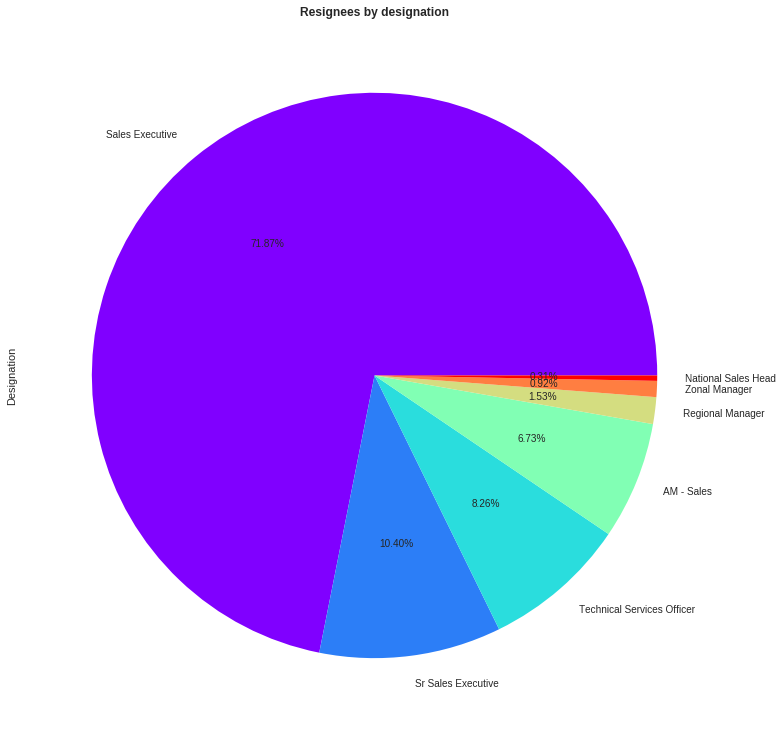

In [182]:
# By designation
data['Designation'].value_counts().plot(kind='pie', figsize=(13, 13), cmap='rainbow', autopct='%1.2f%%')
plt.title('Resignees by designation', fontweight='bold')
plt.savefig('.././plots/resignees_by_designation.png')

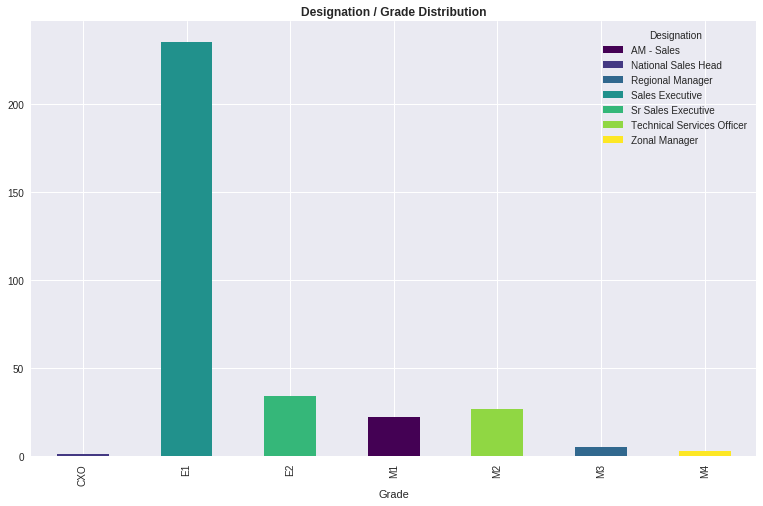

In [157]:
# Designation grade distribution
data.groupby(['Grade'])['Designation'].value_counts().unstack().plot(kind='bar', stacked=True, figsize=(13, 8), cmap='viridis')
plt.title('Designation / Grade Distribution', fontweight='bold')
plt.savefig('.././plots/designation_grade_dist.png')

Two things are apparent from the plots above: One grade correpsonds only to one designation and the lowest designation, of a Sales Executive, has seen the largest number of resignations. This need not imply that the company is leaving only its Sales Executive unhappy: it is possible that they hire a large number of them, of which a small percentage has resigned. 

Either way, it is worth noting that the number of resignations decreases for higher grades (with a small exception between M1 and M2). Perhaps people sitting on top of the ladder are satisfied with their job. We can't say just yet. Below is the distribution of resignations over other columns.

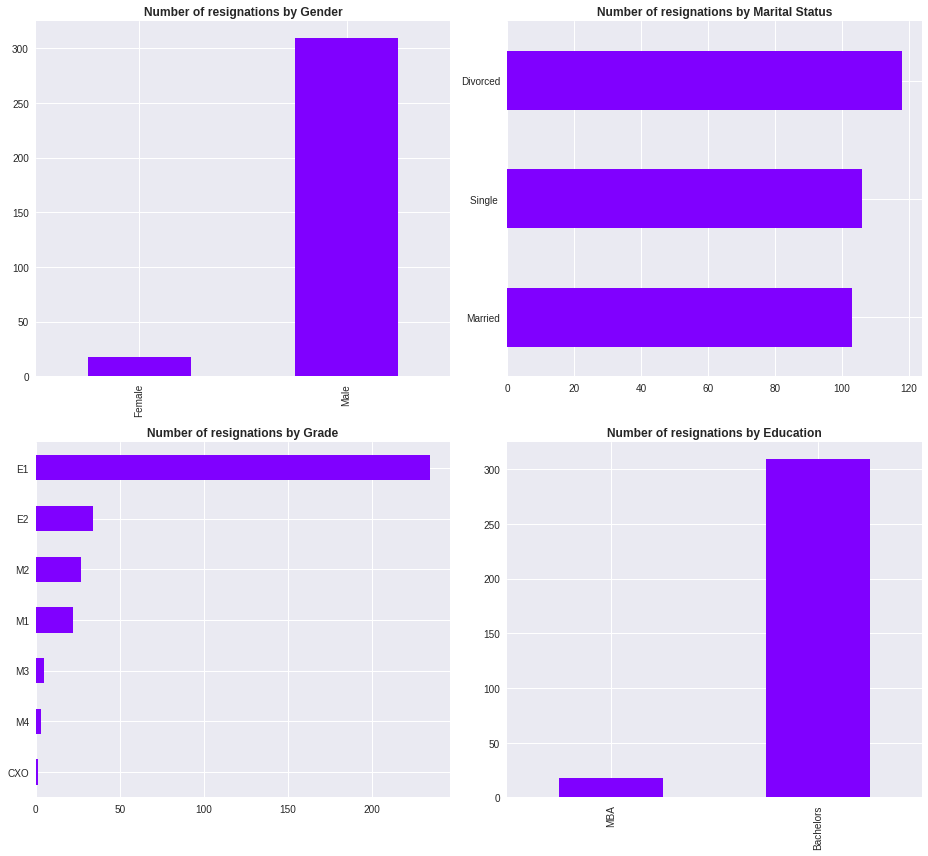

In [158]:
# Resignations distributions
fig = plt.figure(figsize=(26, 24))

# Gender
ax1 = fig.add_subplot(221)
data['Gender'].value_counts().sort_values().plot(kind='bar', figsize=(13, 12), cmap='rainbow')
ax1.set_title('Number of resignations by Gender', fontweight='bold')

# Marital Status
ax2 = fig.add_subplot(222)
data['Marital Status'].value_counts().sort_values().plot(kind='barh', figsize=(13, 12), cmap='rainbow')
ax2.set_title('Number of resignations by Marital Status', fontweight='bold')

# Grade
ax3 = fig.add_subplot(223)
data['Grade'].value_counts().sort_values().plot(kind='barh', figsize=(13, 12), cmap='rainbow')
ax3.set_title('Number of resignations by Grade', fontweight='bold')

# Education
ax4 = fig.add_subplot(224)
data['Education'].value_counts().sort_values().plot(kind='bar', figsize=(13, 12), cmap='rainbow')
ax4.set_title('Number of resignations by Education', fontweight='bold')

plt.tight_layout()
plt.savefig('.././plots/resignations_overview.png')

1. Are more men dissatisfied? Perhaps there's just a lot of them in the company. 
2. It appears that `Marital Status` doesn't influence resignations. Divorcees perhaps wanted a fresh start in life, Single people might have found better opportunities, Married people might want to shift to a different location. We'll investigate this later.
3. This was mentioned earlier, but here it is: resignations explicitly by `Grade`.
4. Nothing to conclude yet, but more people with Bachelor's degrees have resigned. 

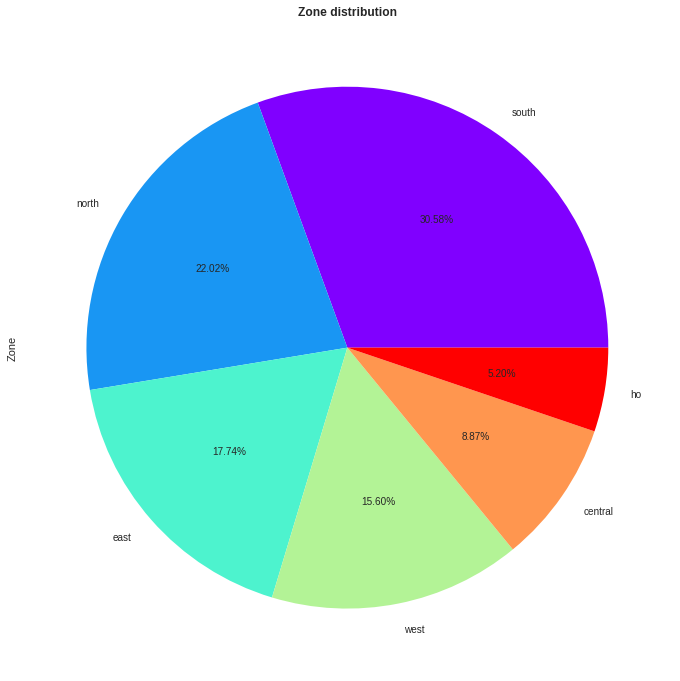

In [183]:
# Zone distribution
data['Zone'].value_counts().plot(kind='pie', figsize=(12, 12), cmap='rainbow', autopct='%1.2f%%')
plt.title('Zone distribution', fontweight='bold')
plt.savefig('.././plots/zone_distribution.png')

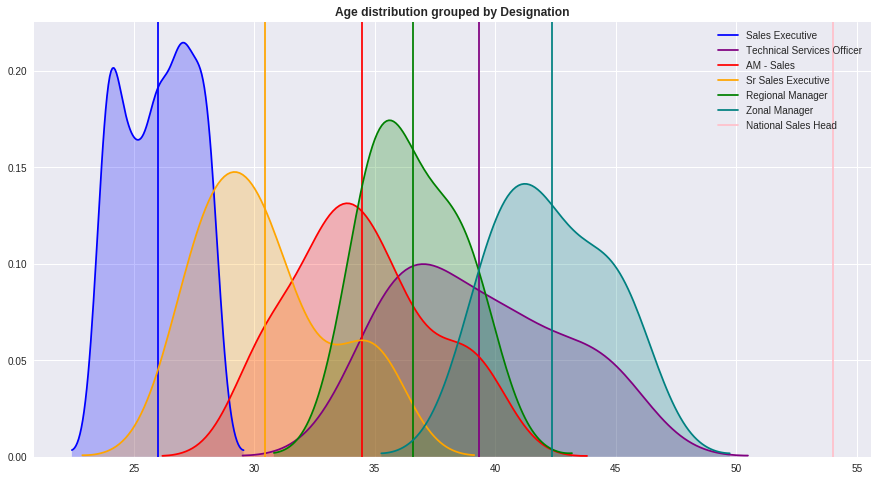

In [159]:
# Age distribution of resignees, gropued by Designation
plt.figure(figsize=(15, 8))
for des, c in zip(data['Designation'].unique(), 
                  ['blue', 'purple', 'red', 'orange', 'green', 'teal', 'pink']):
    tenure_vals = data.query('Designation == @des')['Age'].values
    sns.kdeplot(tenure_vals, shade=True, color=c, label=des)
    plt.axvline(data[data['Designation'] == des]['Age'].mean(), color=c)
plt.title('Age distribution grouped by Designation', fontweight='bold')
plt.legend()
plt.savefig('.././plots/age_dist_by_designation.png')

Interestingly, there is a visible age separation between various designations (and grades). Younger people start off with lower Grade designations, and their older (hopefully more experienced) people take higher designations. The vertical lines depict the mean age for each designation. Only Technical Service Officers have a broader age distribution on the higher end.

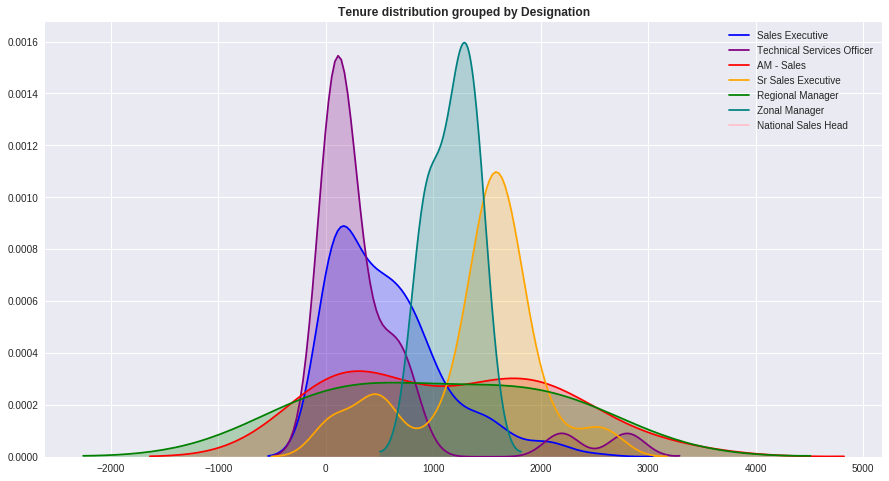

In [184]:
# Distribution of tenure, grouped by Designation
plt.figure(figsize=(15, 8))
for des, c in zip(data['Designation'].unique(), 
                  ['blue', 'purple', 'red', 'orange', 'green', 'teal', 'pink']):
    tenure_vals = data.query('Designation == @des')['Tenure'].values
    sns.kdeplot(tenure_vals, shade=True, color=c, label=des)
plt.title('Tenure distribution grouped by Designation', fontweight='bold')
plt.legend()
plt.savefig('.././plots/tenure_by_designation.png')

Turns out Sales Executives and Technical Service Officers, in general, have had smaller tenures than other Designations. We'll see if we can get something out of this later.

# Why did they leave the company?
An important question that the company must find answers to. In this section, we will investigate possible reasons that made these employees resign. Hopefully, it will also gives us hints on what the company must do to improve their sitaution.

## Remarks
Direct indicator of the reason for their resignation. Let's see what the employees have to say.

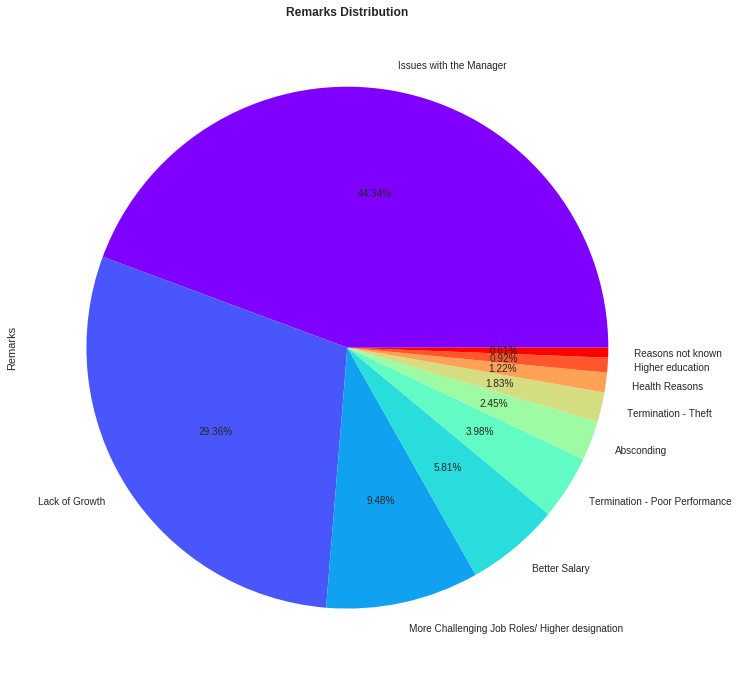

In [163]:
# What remarks did these employees leave?
data['Remarks'].value_counts().plot(kind='pie', figsize=(12, 12), cmap='rainbow', autopct='%1.2f%%')
plt.title('Remarks Distribution', fontweight='bold')
plt.savefig('.././plots/remarks_dist.png')

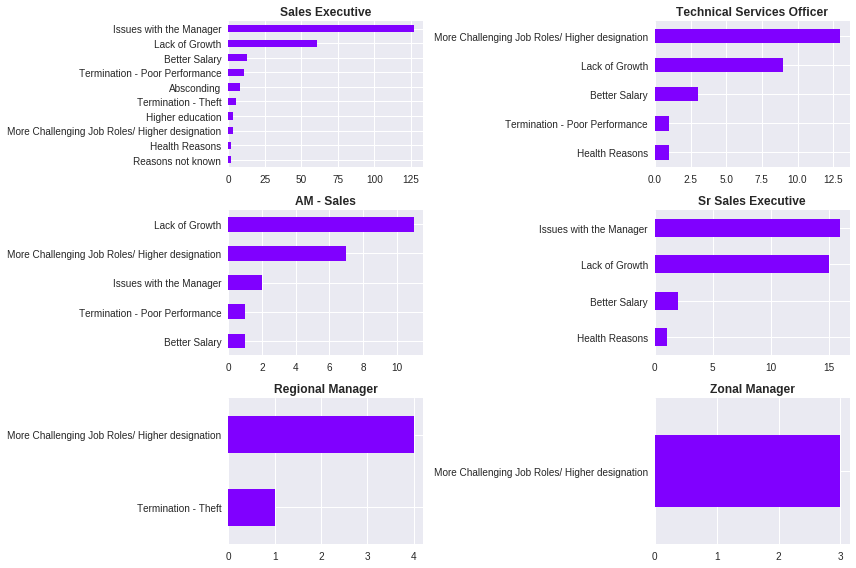

In [164]:
# Remarks distribution by designation
des = data['Designation'].unique().tolist()
fig = plt.figure(figsize=(24, 24))

for i, d in zip(range(1, 7), des):
    ax = fig.add_subplot(3, 2, i)
    data[data['Designation'] == d]['Remarks'].value_counts().sort_values().plot(kind='barh', figsize=(12, 8), cmap='rainbow')
    ax.set_title(d, fontweight='bold')
    
plt.tight_layout()
plt.savefig('.././plots/remarks_by_designation.png')

It is interesting to note that **Issues with the Manager** is a common remark among lower grades like Sales Executives and **More Challenging Roles/Higher Designations** is common among higher grades like TSOs and Managers. This could hint at something important about the company's internal working:
1. People, both at lower and higher grades, want to leave the company. 
2. Lower designations are resigning because they are having trouble with their seniors. Higher designations are resigning because they are unable to find growth opportunities or better salaries (which is the second largest reason for lower grades). This means the company possibly has a toxic environment not conducive to growth. These are only speculations, however.
3. Employees in lower grades have a larger variety of complaints as compared to employees at higher grades. 

## Engagement Scores
Low engagement scores should signify lesser job satisfaction, causing people to leave.

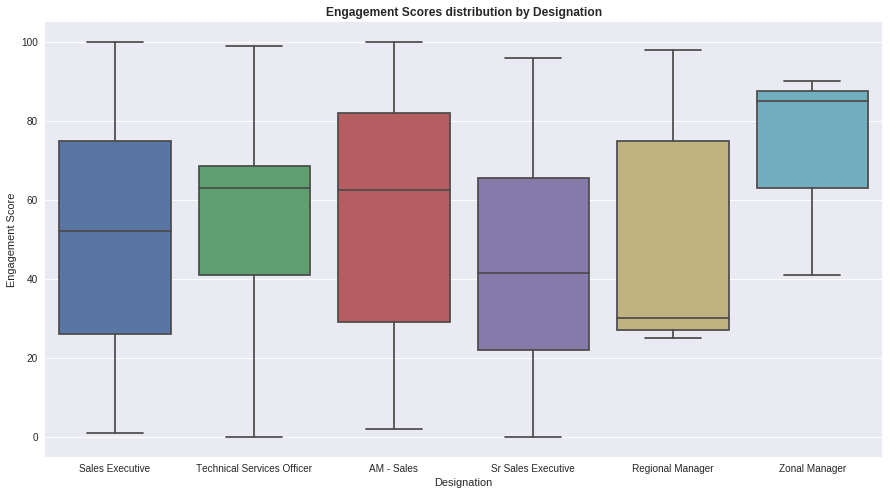

In [165]:
# Distribution of Engagement scores, grouped by Designation
plt.figure(figsize=(15, 8))
data_new = data.drop(data[data['Designation'] == 'National Sales Head'].index, axis=0)
sns.boxplot(x='Designation', y='Engagement Score', data=data_new)
plt.title('Engagement Scores distribution by Designation', fontweight='bold')
plt.savefig('.././plots/engagement_scores_by_designation.png')

Despite the complaints, it seems like quite a good number of them have given good engagement scores. Maybe the company isn't that bad after all. However, we can't neglect the fact that the lower three grades have lower median engagement scores than the higher three grades.

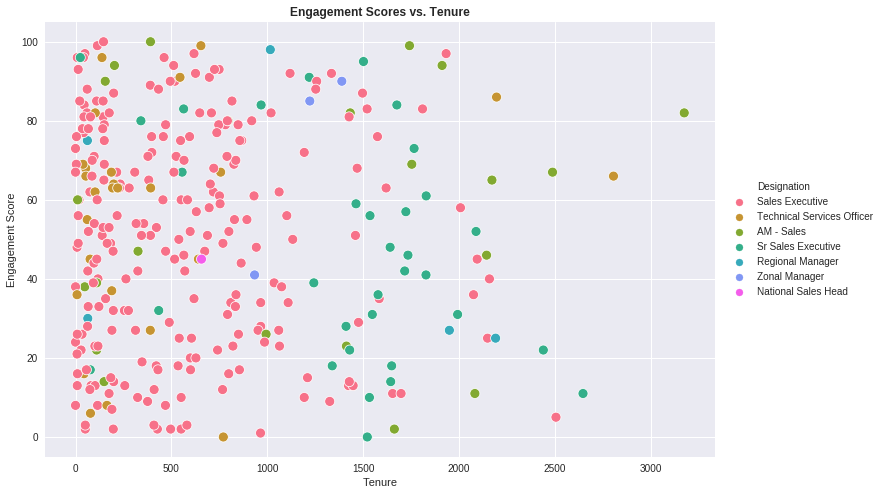

In [166]:
# Engagement Scores versus Tenure
plt.figure(figsize=(12,8))
sns.scatterplot(x='Tenure', y='Engagement Score', data=data, hue='Designation', s=100)
plt.title('Engagement Scores vs. Tenure', fontweight='bold')
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5))
plt.savefig('.././plots/eng_scores_vs_tenure.png')

No observable trend here either. People with short and long tenures have all sorts of engagement scores. 

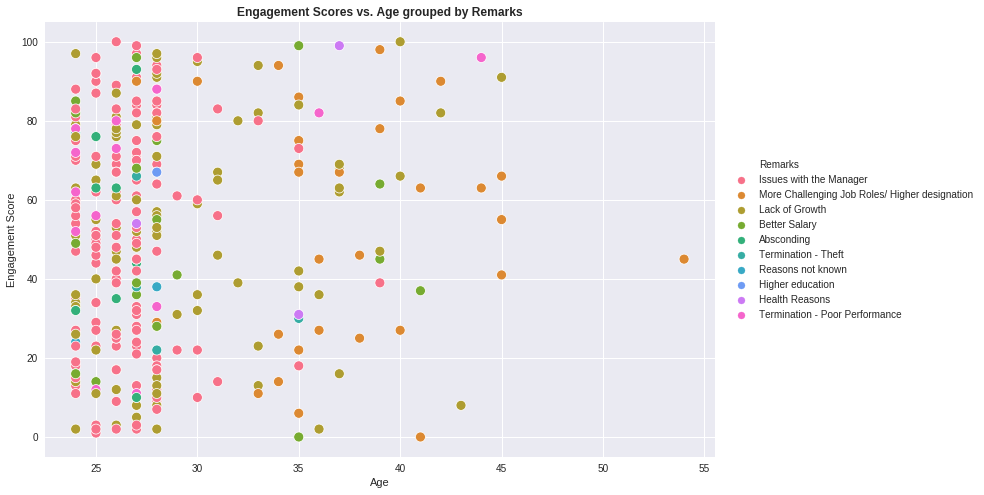

In [167]:
# Engagement Scores versus Age
plt.figure(figsize=(12,8))
sns.scatterplot(x='Age', y='Engagement Score', data=data, hue='Remarks', s=100)
plt.title('Engagement Scores vs. Age grouped by Remarks', fontweight='bold')
plt.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.savefig('.././plots/eng_scores_vs_age.png')

Something about this plot really throws me off. Why do people, who have had issues with their managers, or have been removed for poor performance, have high engagement scores? Is this data organic? Also notice how the younger population has so many issues with their managers, while the older population wants more challenging roles or higher designations. Either way, it seems like engagement scores don't hold any indicators for people's reasons for resignation. On to the next factor.

## Monthly Income
Everyone wants a lot of money. Let's see if it's happening here.

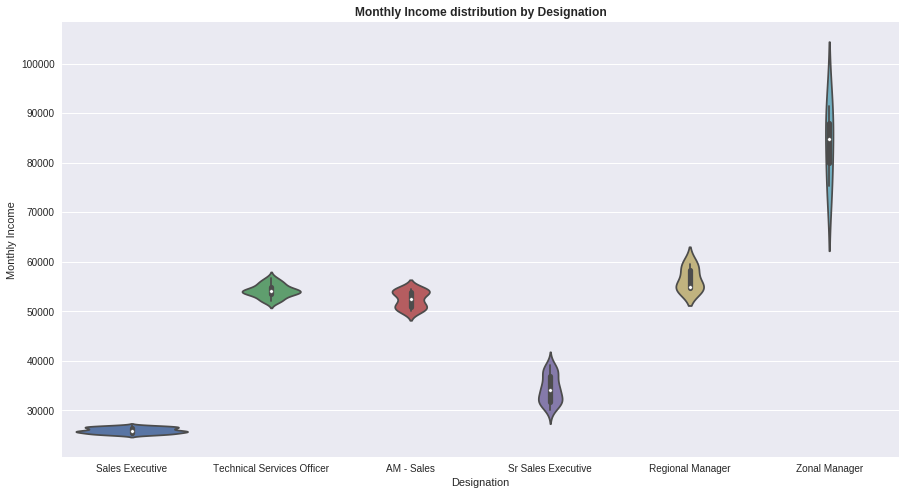

In [185]:
# Distribution of monthly income, grouped by Designation
plt.figure(figsize=(15, 8))
data_new = data.drop(data[data['Designation'] == 'National Sales Head'].index, axis=0)
sns.violinplot(x='Designation', y='Monthly Income', data=data_new)
plt.title('Monthly Income distribution by Designation', fontweight='bold')
plt.savefig('.././plots/monthly_income_by_designation.png')

Interesting. Higher the grade, more the payment. Also, except for AM - Sales, TSOs and Regional Managers, there's little overlap between paycheck distributions. The amount for National Sales Head is not shown because there are too few data points to compute its KDE. However, their average income is almost double the highest income shown here.

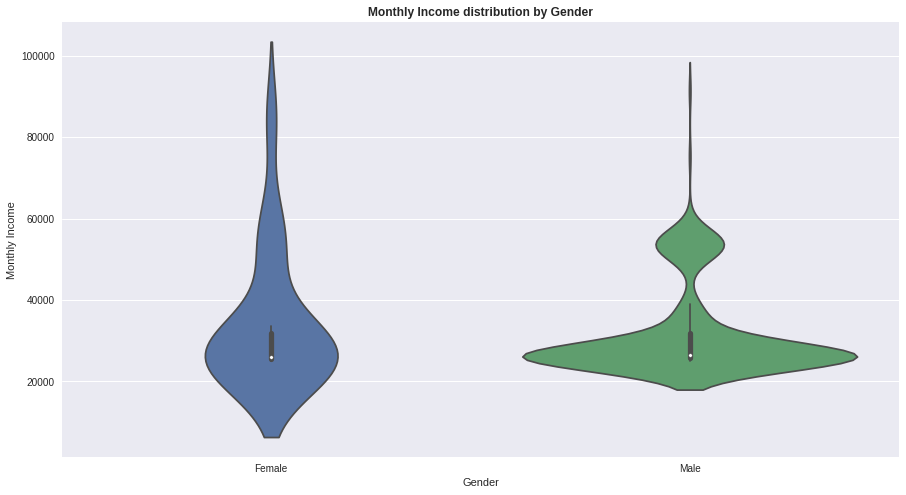

In [186]:
# Distribution of monthly income, grouped by marital status
plt.figure(figsize=(15, 8))
data_new = data.drop(data[data['Designation'] == 'National Sales Head'].index, axis=0)
sns.violinplot(x='Gender', y='Monthly Income', data=data_new)
plt.title('Monthly Income distribution by Gender', fontweight='bold')
plt.savefig('.././plots/monthly_income_by_gender.png')

There are a lot of males being paid between 20,000 and 40,000 compared to females. In the higher pay brackets, there were more females than males. Why did they leave? Maybe they got married, and had to leave their jobs to care for children? Diverting a little bit, but let's see what complaints women had for leaving...

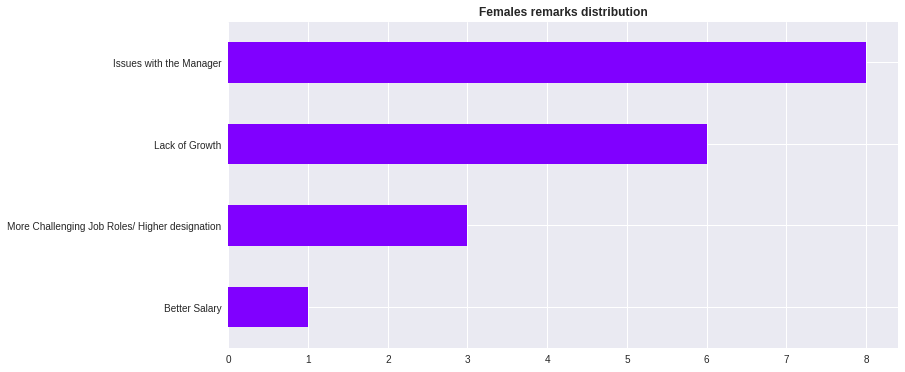

In [187]:
# Women's complaints
plt.figure(figsize=(12, 6))
data[data['Gender'] == 'Female']['Remarks'].value_counts().sort_values().plot(kind='barh', cmap='rainbow')
plt.title('Females remarks distribution', fontweight='bold')
plt.savefig('.././plots/womens_complaints.png')

Turns out no one left their jobs just because they got married. But they had issues with their managers, and they didn't find growth opportunities.

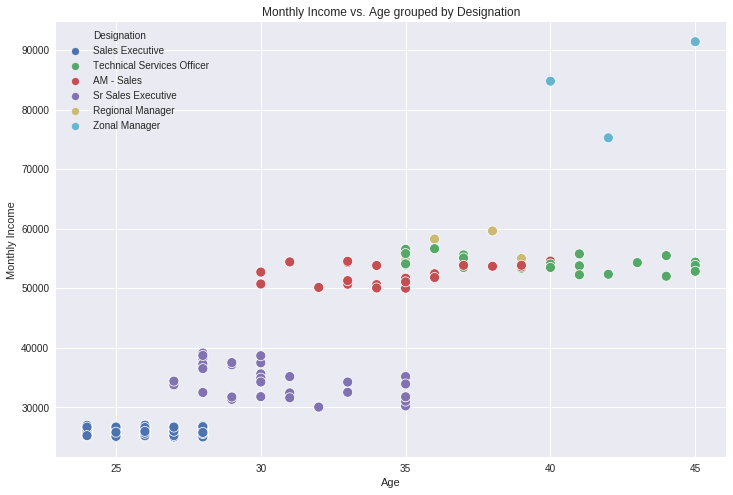

In [175]:
# Monthly income variation with age
data_new = data.drop(data[data['Designation'] == 'National Sales Head'].index, axis=0)
plt.figure(figsize=(12,8))
sns.scatterplot(x='Age', y='Monthly Income', data=data_new, hue='Designation', s=100)
plt.title('Monthly Income vs. Age grouped by Designation')
plt.savefig('.././plots/monthly_income_vs_age.png')

Four income bands are visible. Sales Executives are paid minimum, a little higher come Sr Sales Executives. Regional Managers, AM - Sales and TSOs are paid in the same range. Zonal managers and National Sales Heads (not shown here as it distorts the plot) are paid highest.

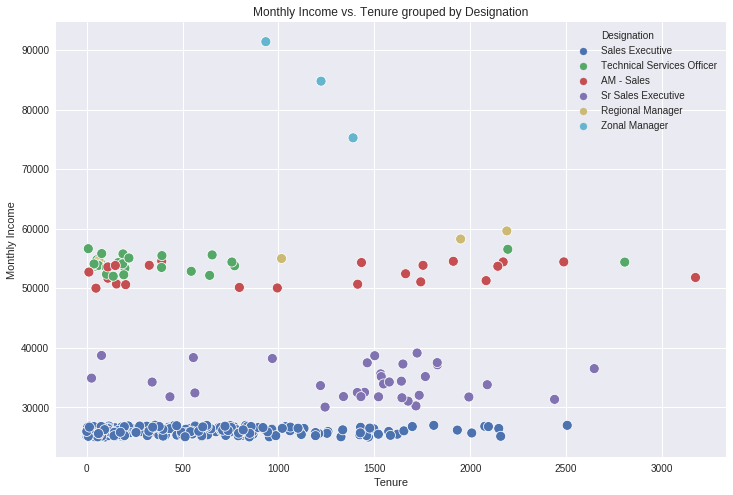

In [176]:
# Monthly income variation with age
data_new = data.drop(data[data['Designation'] == 'National Sales Head'].index, axis=0)
plt.figure(figsize=(12,8))
sns.scatterplot(x='Tenure', y='Monthly Income', data=data_new, hue='Designation', s=100)
plt.title('Monthly Income vs. Tenure grouped by Designation')
plt.savefig('.././plots/monthly_income_vs_tenure.png')

**(IMPORTANT)** Here's another hypothesis: There are sales executives with very large tenures but not much increase in monthly income. This also holds for other designations, when compared to higher designations. This could have frustrated some employees, forcing them to resign. Let's see how `Last Rating` has been varying with `Tenure`.

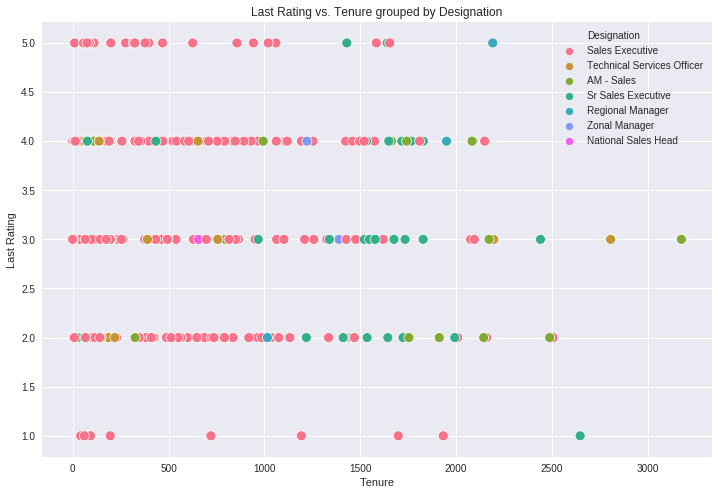

In [177]:
# Monthly income variation with age
plt.figure(figsize=(12,8))
sns.scatterplot(x='Tenure', y='Last Rating', data=data, hue='Designation', s=100)
plt.title('Last Rating vs. Tenure grouped by Designation')
plt.savefig('.././plots/last_rating_vs_tenure.png')

There indeed are some executives at lower grades who haven't been rated well despite their Tenure. Turns out the National Sales Head was no good either. Some evidence for the hypothesis I stated above.

## Other observations
Some other plots, hoping to find some other indicators.

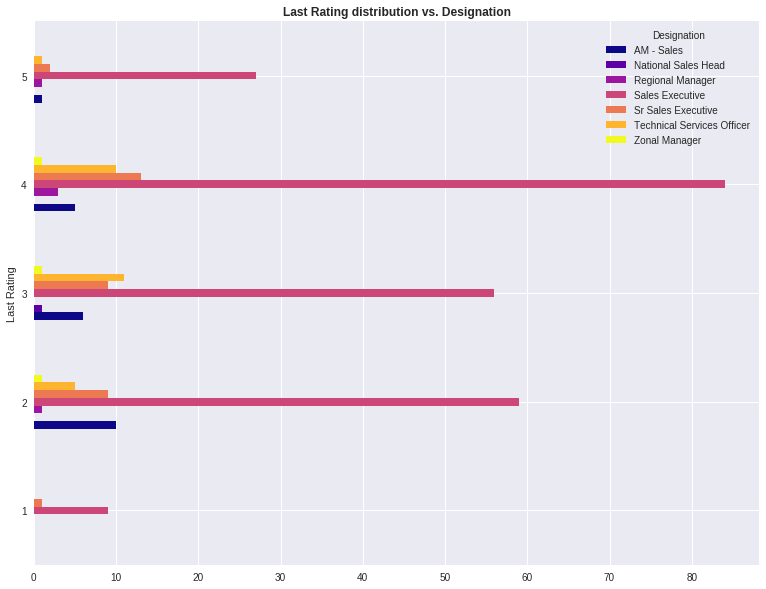

In [178]:
data.groupby(['Last Rating'])['Designation'].value_counts().unstack().plot(kind='barh', figsize=(13, 10), cmap='plasma')
plt.title('Last Rating distribution vs. Designation', fontweight='bold')
plt.savefig('.././plots/last_rating_by_designation.png')

The distribution of last rating seems relatively unbiased, so no indicator here.

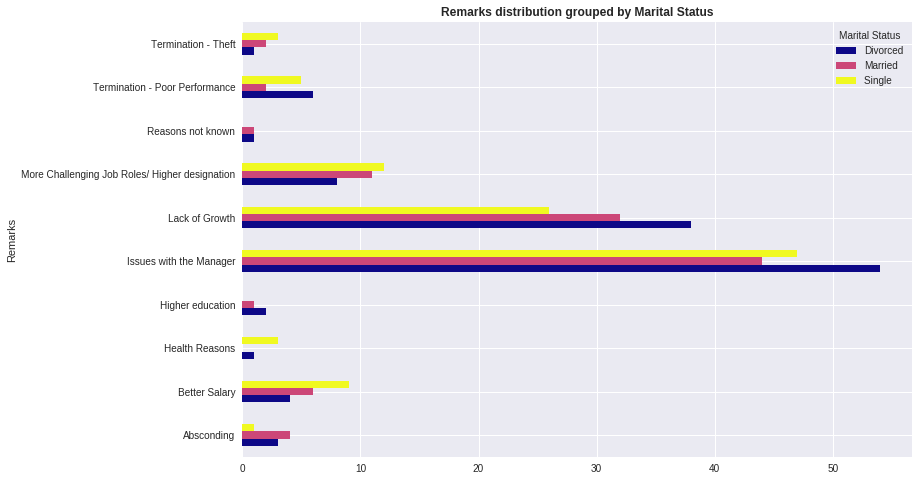

In [179]:
# Is Marital Status resulting in some kinds of issues (Remarks)?
data.groupby(['Remarks'])['Marital Status'].value_counts().unstack().plot(kind='barh', figsize=(12, 8), cmap='plasma')
plt.title('Remarks distribution grouped by Marital Status', fontweight='bold')
plt.savefig('.././plots/remarks_by_marital_status.png')

Divorcees and Single employees are the most common categories in each remark. It would be a great insight to find out if divorcees left their job right after their divorce. Also, single employees perhaps want to find more desirable positions and better salaries before they settle down in life. 

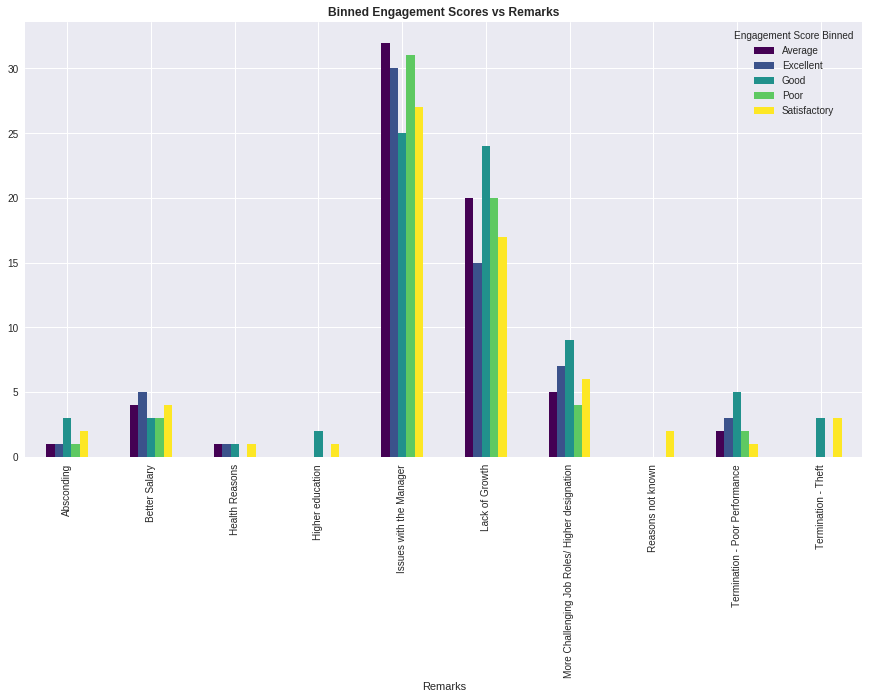

In [180]:
# Binning engagement scores and comparing them with remarks
data['Engagement Score Binned'] = pd.cut(data['Engagement Score'], 5, 
                 labels=['Poor', 'Satisfactory', 'Average', 'Good', 'Excellent'])
data.groupby(['Remarks'])['Engagement Score Binned'].value_counts().unstack().plot(kind='bar', figsize=(15, 8), cmap='viridis')
plt.title('Binned Engagement Scores vs Remarks', fontweight='bold')
plt.savefig('.././plots/binned_eng_scores_by_remarks')

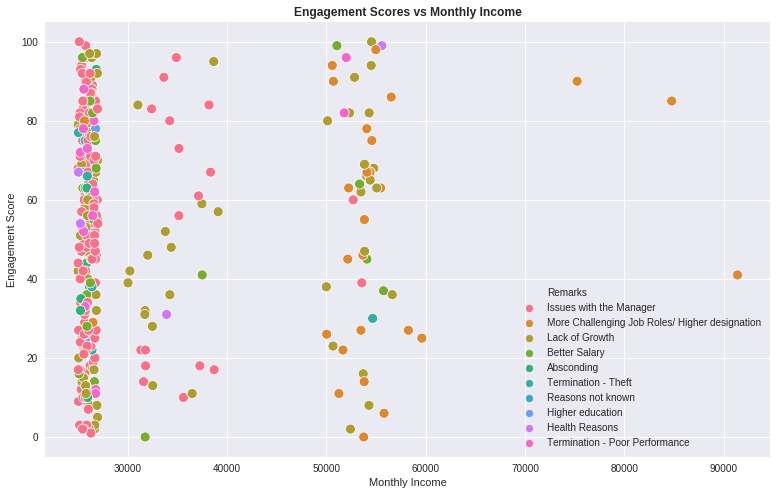

In [181]:
data_new = data.drop(data[data['Designation'] == 'National Sales Head'].index, axis=0)
plt.figure(figsize=(13,8))
sns.scatterplot(x='Monthly Income', y='Engagement Score', data=data_new, hue='Remarks', s=100)
plt.title('Engagement Scores vs Monthly Income', fontweight='bold')
plt.savefig('.././plots/eng_score_by_monthly_income.png')

People with lower income have all sorts of troubles, while people with higher income are mostly looking for growth opportunities. I am honestly thrown off by the fact that people who have had trouble with managers still giving high Engagement scores. Seeing how uniformly it is dustributed, almost makes me feel like the data isn't organic.

# What can the company do to reduce layoff?
Based on the insights we have gained above, here are my suggestions to reduce the number of resignations the company is seeing.

1. **Anonymized Feedback System**: All employees must be given access to a portal where they can voice their concerns, which can include trouble with managers, insufficient growth opportunities or low salary (with justification, maybe). Collected feedback should be duly analyzed and results must be shared with concerned employees so that required amends can be made.
2. **Pay based on work quality and experience**: Rather than having fixed income boundaries for designations, the company must adopt a system where experience and well-performing employees can be promoted to higher levels or given appraisals.
3. I believe that the engagement scores given in this data aren't organic. Perhaps the executives should pay a little more attention to the way this data is collected.